# Automated Choice of Features

We saw a lot of possibilities to add features by transforming current features. Too much features increase the risk of Overfitting.

In [1]:
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
import pandas as pd
import mglearn
from IPython import display

## Univariate Statistics

A feature gets canceled if its only significant in combination with another feature (p-value).

[ True  True  True  True  True  True  True  True  True False  True False
  True  True False  True False  True False False  True  True  True  True
  True  True  True  True  True  True False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False]


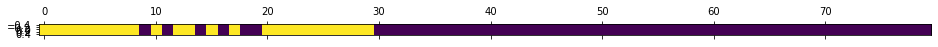

In [26]:
from sklearn.datasets import load_breast_cancer
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()

rng = np.random.RandomState(42)
noise = rng.normal(size=(len(cancer.data),50))

# We add noise (50 datasets, therefore 30 real data sets and in total 80)

X_w_noise = np.hstack([cancer.data,noise])

X_train, X_test, y_train, y_test = train_test_split(X_w_noise,cancer.target, test_size=0.5 ,random_state=0)

select = SelectPercentile(percentile = 30)
select.fit(X_train,y_train)

X_train_selected = select.transform(X_train)

mask = select.get_support()

print(mask)
plt.matshow(mask.reshape(1,-1))

Nearly perfect.

In [27]:
from sklearn.linear_model import LogisticRegression


X_test_selected = select.transform(X_test)

lr = LogisticRegression()
lr.fit(X_train, y_train)
print(lr.score(X_test,y_test))

lr = LogisticRegression()
lr.fit(X_train_selected, y_train)
print(lr.score(X_test_selected,y_test))

0.9192982456140351
0.9614035087719298


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

## Model-based Choice

We use a supervised ML Algo to find the most significant features. We have to define a measure for significance to then make a ranking of the features. (Parameter like ridge, lasso or feature_importances_ in decision trees can help to put weight directley in the model on significance). Model-based considers also interaction between features.

In [45]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

select = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state = 42),
                        threshold = 0.003)

SelectFromModel chooses all features with a measure over the threshold.

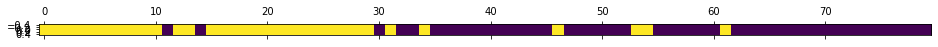

In [46]:
select.fit(X_train,y_train)
X_train_l1 = select.transform(X_train)

mask = select.get_support()
plt.matshow(mask.reshape(1,-1))

In [47]:
X_test_l1 = select.transform(X_test)
LogisticRegression().fit(X_train_l1,y_train).score(X_test_l1,y_test)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9438596491228071

## Iterative Choice

We use a series of models: 

Eather start with no feature and add features until some stop condition is satisfied or we start with all and delet them until some stop condition is satisfied.

In [51]:
from sklearn.feature_selection import RFE

select = RFE(RandomForestClassifier(n_estimators=100, random_state = 42),
            n_features_to_select=30)

select.fit(X_train,y_train)

RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=30)

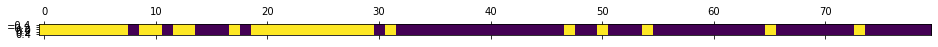

In [52]:
select.fit(X_train,y_train)
mask = select.get_support()
plt.matshow(mask.reshape(1,-1))

In [53]:
X_train_rfe = select.transform(X_train)
X_test_rfe = select.transform(X_test)

LogisticRegression().fit(X_train_rfe,y_train).score(X_test_rfe,y_test)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9473684210526315

In [54]:
select.score(X_test,y_test)

0.9333333333333333

## Expertise

If some knowledge is not included in the data. For example seasonality.

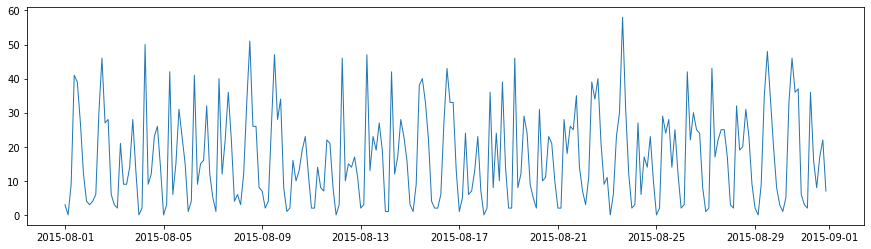

In [55]:
citibike = mglearn.datasets.load_citibike()

plt.figure(figsize=(15,4))
plt.plot(citibike, linewidth=1)

In [63]:
# Values
y = citibike.values
# change time to POSIX-time (seconds since 1.1.1970 00:00:00)
X = citibike.index.strftime("%s").astype("int")
X = np.array(X).reshape(-1,1)
# first 184 to train
n_train = 184

def eval_on_features(features,target,regressor):
    X_train, X_test = features[:n_train], features[n_train:]
    y_train, y_test = target[:n_train], target[n_train:]
    regressor.fit(X_train,y_train)
    print(regressor.score(X_test,y_test))
    y_pred = regressor.predict(X_test)
    y_pred_train = regressor.predict(X_train)
    plt.figure(figsize=(15,4))
    plt.plot(range(n_train), y_train, label ="Training")
    plt.plot(range(n_train, len(y_test) + n_train),y_test,'-', label ="Test")
    plt.plot(range(n_train), y_pred_train,'--', label ="Prediction Training")
    plt.plot(range(n_train, len(y_test) + n_train),y_pred,'--', label ="Prediction Test")
    plt.legend(loc=(1.01,0))
    

-0.035486463625959086


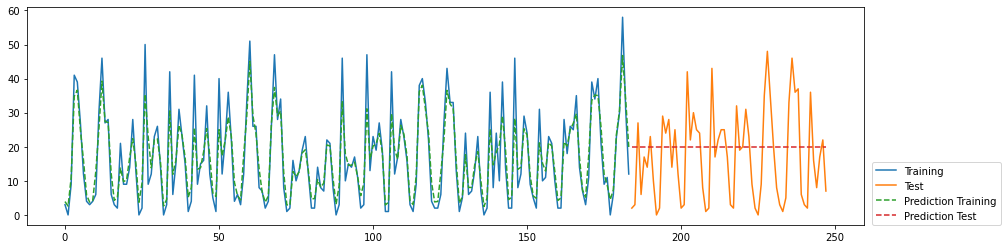

In [64]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
eval_on_features(X,y,regressor)

Trees and Random Forests can not extrapolate. Our Expertise is that the daytime and weekday are important. Therefore the POSIX-time is not the right choice.

[[ 0]
 [ 3]
 [ 6]
 [ 9]
 [12]
 [15]
 [18]
 [21]
 [ 0]
 [ 3]]
0.5995775993305429


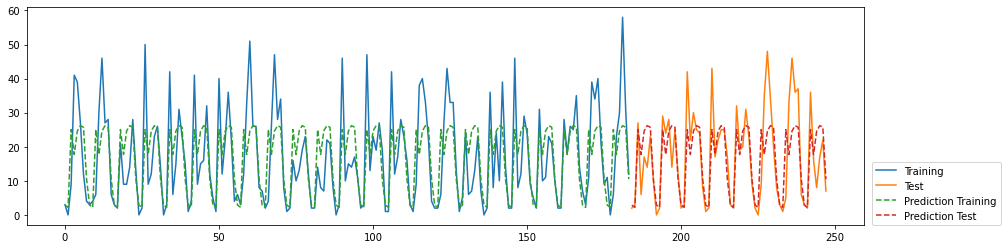

In [68]:
# Daily times
X_hour = citibike.index.hour
X_hour = np.array(X_hour).reshape(-1,1)
print(X_hour[:10])
eval_on_features(X_hour,y,regressor)

[[ 5  0]
 [ 5  3]
 [ 5  6]
 [ 5  9]
 [ 5 12]
 [ 5 15]
 [ 5 18]
 [ 5 21]
 [ 6  0]
 [ 6  3]]
0.8419488587966024


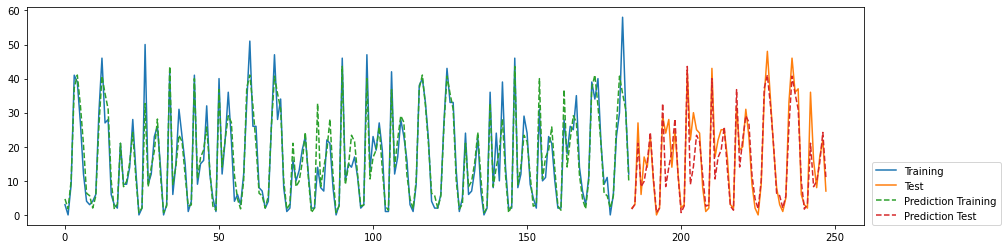

In [70]:
# With weekday
X_hour_w = citibike.index.dayofweek
X_hour_w = np.array(X_hour_w).reshape(-1,1)
X_hour_week = np.hstack([X_hour_w,X_hour])
print(X_hour_week[:10])
eval_on_features(X_hour_week,y,regressor)